In [1]:
# Imports necessários
import sys
sys.path.insert(0, '../src')

import pandas as pd
import matplotlib.pyplot as plt

# Import das funções do pipeline
from crypto_ts_forecast.pipelines.data_processing.nodes import (
    create_prophet_dataset,
    add_features,
    split_train_test
)

## 1. Carregar Dados Validados

In [2]:
# Carregar dados do pipeline anterior
validated_data = pd.read_parquet('../data/02_intermediate/bitcoin_validated.parquet')

print(f"Dados carregados: {len(validated_data)} registros")
print(f"Período: {validated_data['timestamp'].min()} até {validated_data['timestamp'].max()}")
validated_data.head()

Dados carregados: 1825 registros
Período: 2021-01-04 00:00:00 até 2026-01-02 00:00:00


,timestamp,open,high,low,close,volume,close_time,quote_volume,trades,taker_buy_base,taker_buy_quote
0,2021-01-04,33000.05,33600.00,28130.0,31988.71,140899.885690,2021-01-04 23:59:59.999,4.429010e+09,2642408,69088.46923000,2173435409.01698791
1,2021-01-05,31989.75,34360.00,29900.0,33949.53,116049.997038,2021-01-05 23:59:59.999,3.743617e+09,2526851,59691.75475500,1927195093.64154965
2,2021-01-06,33949.53,36939.21,33288.0,36769.36,127139.201310,2021-01-06 23:59:59.999,4.431954e+09,2591783,63052.91465200,2199632470.22154891
3,2021-01-07,36769.36,40365.00,36300.0,39432.28,132825.700437,2021-01-07 23:59:59.999,5.062570e+09,2814686,65055.10713600,2482583239.85649706
4,2021-01-08,39432.48,41950.00,36500.0,40582.81,139789.957499,2021-01-08 23:59:59.999,5.568443e+09,2925632,67300.15521600,2684975445.97890497


## 2. Criar Dataset no Formato Prophet

In [3]:
# Parâmetros
PRICE_COLUMN = "close"  # Usar preço de fechamento

# Criar dataset Prophet (requer colunas 'ds' e 'y')
prophet_base = create_prophet_dataset(
    validated_data=validated_data,
    price_column=PRICE_COLUMN
)

print(f"Dataset Prophet criado: {len(prophet_base)} registros")
print(f"Colunas: {list(prophet_base.columns)}")
prophet_base.head()

Dataset Prophet criado: 1825 registros
Colunas: ['ds', 'y']


,ds,y
0,2021-01-04,31988.71
1,2021-01-05,33949.53
2,2021-01-06,36769.36
3,2021-01-07,39432.28
4,2021-01-08,40582.81


In [4]:
# Verificar formato correto para Prophet
print("Verificação do formato Prophet:")
print(f"- Coluna 'ds' presente: {'ds' in prophet_base.columns}")
print(f"- Coluna 'y' presente: {'y' in prophet_base.columns}")
print(f"- Tipo de 'ds': {prophet_base['ds'].dtype}")
print(f"- Tipo de 'y': {prophet_base['y'].dtype}")

Verificação do formato Prophet:
- Coluna 'ds' presente: True
- Coluna 'y' presente: True
- Tipo de 'ds': datetime64[ns]
- Tipo de 'y': float64


## 3. Adicionar Features (Opcional)

In [5]:
# Adicionar volume como feature (opcional)
ADD_VOLUME = False  # Mudar para True se quiser adicionar volume

prophet_full = add_features(
    prophet_df=prophet_base,
    add_volume=ADD_VOLUME,
    validated_data=validated_data
)

print(f"Dataset com features: {len(prophet_full)} registros")
print(f"Colunas: {list(prophet_full.columns)}")
prophet_full.head()

Dataset com features: 1825 registros
Colunas: ['ds', 'y']


,ds,y
0,2021-01-04,31988.71
1,2021-01-05,33949.53
2,2021-01-06,36769.36
3,2021-01-07,39432.28
4,2021-01-08,40582.81


## 4. Split Train/Test

In [6]:
# Parâmetros de split
TEST_SIZE_DAYS = 30

# Dividir dados
train_data, test_data = split_train_test(
    prophet_df=prophet_full,
    test_size_days=TEST_SIZE_DAYS
)

print(f"Dados de treino: {len(train_data)} registros")
print(f"Dados de teste: {len(test_data)} registros")
print(f"\nPeríodo de treino: {train_data['ds'].min()} até {train_data['ds'].max()}")
print(f"Período de teste: {test_data['ds'].min()} até {test_data['ds'].max()}")

Dados de treino: 1795 registros
Dados de teste: 30 registros

Período de treino: 2021-01-04 00:00:00 até 2025-12-03 00:00:00
Período de teste: 2025-12-04 00:00:00 até 2026-01-02 00:00:00


## 5. Visualização do Split

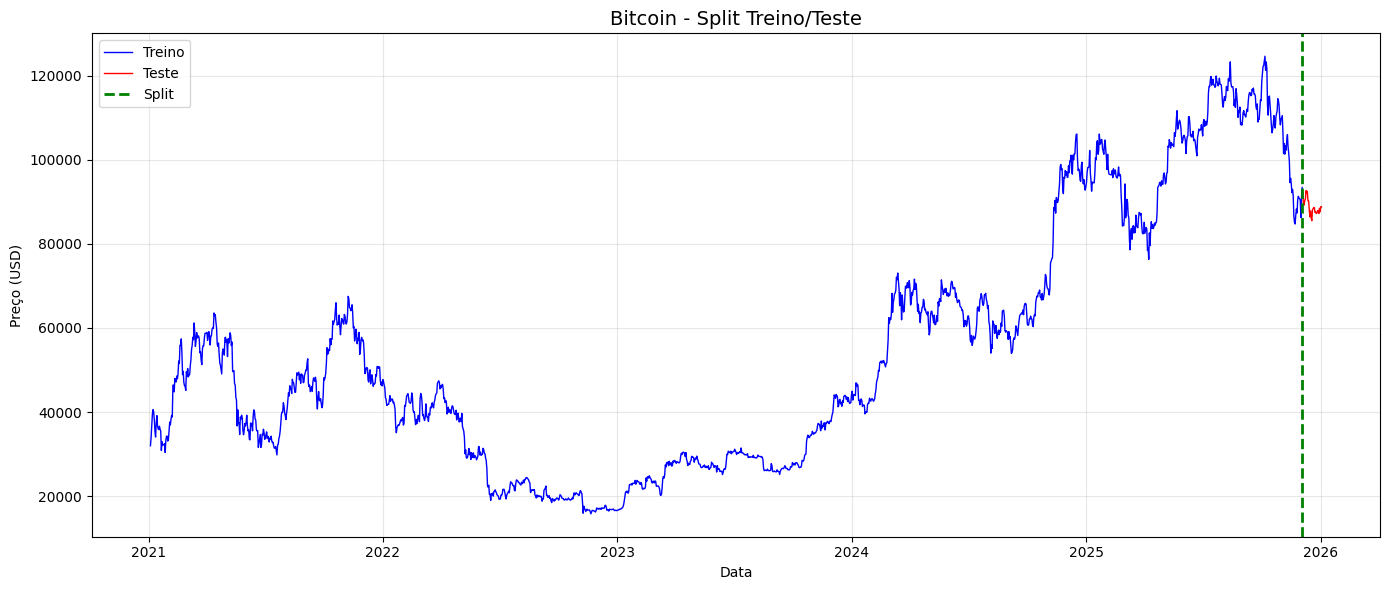

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot treino
ax.plot(train_data['ds'], train_data['y'], 'b-', label='Treino', linewidth=1)

# Plot teste
ax.plot(test_data['ds'], test_data['y'], 'r-', label='Teste', linewidth=1)

# Linha de divisão
split_date = train_data['ds'].max()
ax.axvline(x=split_date, color='green', linestyle='--', label='Split', linewidth=2)

ax.set_title('Bitcoin - Split Treino/Teste', fontsize=14)
ax.set_xlabel('Data')
ax.set_ylabel('Preço (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Salvar datasets
prophet_full.to_parquet('../data/04_feature/prophet_full.parquet', compression='gzip')
train_data.to_parquet('../data/05_model_input/train_data.parquet', compression='gzip')
test_data.to_parquet('../data/05_model_input/test_data.parquet', compression='gzip')

print("Datasets salvos!")

Datasets salvos!
